## Imports 

In [1]:
import numpy as np
import scipy as sc
import pandas as pd
from matplotlib import pyplot as plt
from signal_loader import load_signals
from carnalife.preprocessing.denosing.denoise import Denoise, HPDenoise
import biosppy, pyhrv
import random, math
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, matthews_corrcoef, balanced_accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from collections import Counter
from imblearn.over_sampling import SMOTE

## Feature extraction 
Two sets of feature were used for a model. Below FS2 set is extracted from data and implemented, which consist of RR intervals (pre, post, av local and global) and fixed interval morphology features (qrs part of signal and t).

### RR intervals

In [2]:
# Features RR_intervals - for whole signal
def rr_intervals(r_loc):
    
    '''
    Returns:
    RR interval feature values for every peak in signal
        pre_r - array, time interval between current peak and previous one
        post_r - array, time interval between current peak and next one
        av_local - array, local average of time interval of 10 past intervals 
            before current peak or less for first 10 peaks
        av_global - array, global average of time interval through out the whole signal
            same value for every peak in signal
        
    Parameter:  r_loc - array, location od detected R peaks
    '''
    
    pre_r = np.array([], dtype=int)
    post_r = np.array([], dtype=int)
    av_local = np.array([], dtype=float)
    av_global = np.array([], dtype=float)
    local_arr = np.array([], dtype=float)
    
    # first values
    pre_r = np.append(pre_r, 0)
    post_r = np.append(post_r, r_loc[1] - r_loc[0])

    for i in range(1, len(r_loc)-1):
        pre_r = np.append(pre_r, r_loc[i] - r_loc[i-1])
        post_r = np.append(post_r, r_loc[i+1] - r_loc[i])
        
    # last values
    pre_r[0] = pre_r[1]
    pre_r = np.append(pre_r, r_loc[-1] - r_loc[-2])  
    post_r = np.append(post_r, post_r[-1])

    for i, val in enumerate(r_loc):
        local_arr = []
   
        if i > 9:
            k = 10
        else:
            k = i
        
        for j in range(k):
            local_arr = np.append(local_arr, pre_r[i-j])
        
        if len(local_arr) == 0:
            local_arr = np.append(local_arr, pre_r[0])
            
        av = np.mean(local_arr)
        av_local = np.append(av_local, pre_r[i]/av)
        av_global = np.append(av_global, np.mean(pre_r) - av)
    #av_global = np.full((len(pre_r)), np.mean(pre_r))
    
    return [pre_r, post_r, av_local, av_global]

### Fixed intervals morphology features

In [3]:
# Fixed interval morphology features 
def fixed_interval_morphology_features(signal, r_loc, Fs):
    
    '''
    Returns:
    Fixed interval morphology features of peaks in ecg signal
        qrs_int - array, refers to qrs amplitude values
            as qrs interval it takes 9 samples 50ms before fiducial point (R peak) and 100ms after fiducial point
        t_int - array, refers to t amplitude values
            as t interval it takes 9 samples 150ms after fiducial point (R peak) till 500ms after fiducial point
    
    Parameters:
    signal - array, ecg signal 
    r_loc - array, r peaks locations
    Fs - int, sampling frequency
    '''
    
    qrs_int = np.zeros([len(r_loc),8])
    t_int = np.zeros([len(r_loc),8])
    
    for i, val in enumerate(r_loc):
        if val + round(Fs * 0.5) < len(signal):
            
            qrs_int[i]= sc.signal.resample(signal[np.arange(val - round(Fs * 0.05), val + round(Fs * 0.1))], 8)
            t_int[i] = sc.signal.resample(signal[np.arange(val + round(Fs * 0.15), val + round(Fs * 0.5))], 8)
            
        else:
            qrs_int[i] = np.zeros(8) * np.nan
            t_int[i] = np.zeros(8) * np.nan
            
        qrs_int[i] = qrs_int[i]/np.max(qrs_int[i])
        t_int[i] = t_int[i]/np.max(t_int[i])
        
        
    return [qrs_int, t_int]

### Feature mean matrix 
Only for RR intervals, because it wasn't used further

In [4]:
# Fix with locations of desired class peaks
def rr_intervals_for_class(r_loc, class_loc):
    
    '''
    Returns:
    Means of RR interval feature values for desired class of heartbeat [N,S,V]
        pre_r - float, time interval between current peak and previous one
        post_r - float, time interval between current peak and next one
        av_local - float, local average of time interval of 10 past intervals 
            before current peak or less for first 10 peaks
        av_global - float, global average of time interval through out the whole signal
            same value for every peak in signal
            
    Used for feature mean matrix
    
    Parameters:  
    r_loc - array, location of detected R peaks 
    class_loc - array, location of peaks of desired class [N,S,V]  
    '''
    
    pre_r = np.array([], dtype=int)
    post_r = np.array([], dtype=int)
    av_local = np.array([], dtype=float)
    local_arr = np.array([], dtype=float)
    
    # first values
    pre_r = np.append(pre_r, 0)
    post_r = np.append(post_r, r_loc[np.where(r_loc == class_loc[0])[0]+1] - class_loc[0])

    for i in range(1, len(class_loc)-1):
        pre_r = np.append(pre_r, class_loc[i] - r_loc[np.where(r_loc == class_loc[i])[0]-1])
        post_r = np.append(post_r, r_loc[np.where(r_loc == class_loc[i])[0]+1] - class_loc[i])

    # last values
    if len(pre_r) > 1:
        pre_r[0] = pre_r[1]
        
    pre_r = np.append(pre_r, class_loc[-1] - r_loc[np.where(r_loc == class_loc[-1])[0]-1])  
    post_r = np.append(post_r, post_r[-1])

    
    for loc in class_loc: 
        local_arr = []
        index = np.where(r_loc == loc)
        
        if index[0][0] > 9:
            k = 10
        else:
            k = index[0][0]
        
        for j in range(k):
            rr_int = r_loc[index[0][0]-j] - r_loc[index[0][0]-j-1]
            local_arr = np.append(local_arr, rr_int)
        
        if len(local_arr) == 0:
            continue
             
        av = np.mean(local_arr)
        av_local = np.append(av_local, av)
        
    
    av_global = np.mean([pre_r, post_r]) 
    
    return [np.mean(pre_r), np.mean(post_r), np.mean(av_local), av_global]

def feature_mean_matrix(data):
    d = {}
    classes = np.array(['N','S','V'])
    Fs = data['sampling_rate']
    
    for cl in classes:
        indices = np.where(data['classes'] == cl)
       
        if len(indices[0]) > 0:
            peak_loc = data['peaks'][indices]
            peak_loc_s = peak_loc/Fs
            data_s = data['peaks']/Fs
            a = rr_intervals_for_class(data_s, peak_loc_s)
            #b = fixed_interval_morphology_features(data['signal'], peak_loc, Fs)
            b = []
            d.update({cl: np.concatenate((a,b))})
        else:
            continue
        
    return pd.DataFrame(d, index=['Pre-RR interval', 'Post-RR interval', 'Local avg. RR-interval', 'Global avg. RR-interval'])

### Data preparation

In [5]:
def X_prepare(mitdb, correct_peaks=True, filtr=True):
    '''
    Returns:
    X - pandas dataframe, set of features for every peak in the database
    
    Parameter:
    mitdb - database loaded by load_signals function
    '''
    X = pd.DataFrame()
    #column_name=['Pre-RR interval', 'Post-RR interval', 'Local avg. RR-interval', 'Global avg. RR-interval', 'QRS interval 1','QRS interval 2','QRS interval 3','QRS interval 4', 'QRS interval 5','QRS interval 6','QRS interval 7','QRS interval 8','QRS interval 9','T interval 1','T interval 2','T interval 3','T interval 4','T interval 5','T interval 6','T interval 7','T interval 8','T interval 9']
    column_name=['Pre-RR interval', 'Post-RR interval', 'Local avg. RR-interval', 'Global avg. RR-interval', 'QRS interval 1','QRS interval 2','QRS interval 3','QRS interval 4', 'QRS interval 5','QRS interval 6','QRS interval 7','QRS interval 8','T interval 1','T interval 2','T interval 3','T interval 4','T interval 5','T interval 6','T interval 7','T interval 8']
    
    for i in mitdb:
        
        sampling_rate = mitdb[i]['sampling_rate']
        
        if filtr:
            hp = Denoise()
            mitdb[i]['signal'] = hp.filter(signal=mitdb[i]['signal'], fs=sampling_rate)
        #else:
         #   signal = mitdb[i]['signal']
        
        if correct_peaks:
            mitdb[i] = correct_peak_loc(mitdb[i])
        
        peaks = mitdb[i]['peaks']
        signal = mitdb[i]['signal']
        arr = rr_intervals(peaks / sampling_rate)
        #biosppy.ecg.ecg(mitdb[i]['signal'], sampling_rate, show=False)['filtered']
        fx_int = fixed_interval_morphology_features(signal, peaks, sampling_rate)
   
       
        for j, fx in enumerate(fx_int[0].T):
            arr.append(fx_int[0].T[j])
            arr.append(fx_int[1].T[j]) 
        
        df_concat = pd.DataFrame()
        
        for k, val in enumerate(arr):
            df = pd.DataFrame(val, columns=[column_name[k]])
      
            df_concat = pd.concat([df_concat, df],axis=1)
            
        X = pd.concat([X, df_concat], axis=0, ignore_index=True)
        
    return X 

def y_prepare(mitdb):
    '''
    Returns:
    y - pandas dataframe, set of classes assigned for every peak in database
    
    Parameter:
    mitdb -  database loaded by load_signals function
    '''
    y = pd.DataFrame()
    for i in mitdb:
        y_temp = mitdb[i]['classes'].copy()
   
        for j, val in enumerate(y_temp):
            if val == 'N':
                y_temp[j] = 0
            elif val =='S':
                y_temp[j] = 1
            elif val == 'V':
                y_temp[j] = 2
         
            
        y = pd.concat([y,pd.DataFrame(y_temp)], ignore_index=True)
        
    return np.asarray(y[0]).astype(int)

### Other preprocessing functions

In [6]:
def resample_db(db, fs):
    for i in db:
        db[i]['signal'] = sc.signal.resample(db[i]['signal'], round(len(db[i]['signal'])*fs/db[i]['sampling_rate']))
        new_peak = np.round(db[i]['peaks']/db[i]['sampling_rate'] * fs)
        db[i]['peaks'] = new_peak.astype(int)
        db[i]['sampling_rate'] = fs

def del_other_classes(db):
    for i in list(db):
        classes = db[i]['classes']
        peaks = db[i]['peaks']
        loc = np.array([], dtype=int)
        for j,val in enumerate(classes):
            if (val != 'N') and (val != 'S') and (val != 'V'):
                loc = np.append(loc,[j])
        classes =  np.delete(classes,loc)
        peaks = np.delete(peaks,loc)
        
        db[i]['classes'] = classes
        db[i]['peaks'] = peaks
        
        if len(db[i]['signal'])/db[i]['sampling_rate'] < 10 or len(peaks) < 2:
            del db[i]
    #set new proper keys 
        
    d1 = dict(enumerate(db))
    for key, value in d1.items():
        db[key] = db.pop(value)

# GET RID OF NANS IN FIXED INTERVAL MORPHOLOGY FEATURES
def del_nans(X, y):
    nan_indices = np.array(X.loc[pd.isna(X['QRS interval 1']), :].index)
    y = np.delete(y, nan_indices)
    X = X.drop(nan_indices)
    X.reset_index()
    return X,y

# CORRECT PEAK LOCATION - IN SOME DBS (INCLUDING MITDBSVT AND MEDAPP) THE PEAKS ARE DISPLACED 
def correct_peak_loc(signal):
    pred_peaks = biosppy.signals.ecg.correct_rpeaks(signal=signal['signal'], rpeaks=signal['peaks'], sampling_rate=signal['sampling_rate'])[0]
    
    if len(pred_peaks) != len(signal['peaks']):
        correct_indices = biosppy.ecg.compare_segmentation(pred_peaks, signal['peaks'], sampling_rate=signal['sampling_rate'], tol = 0.1)['match']
        p = [i for i, v in enumerate(signal['peaks'])]
        check = [el not in correct_indices for el in p]
        q = [i for i,v in enumerate(check) if not v]
        signal['peaks'][q] = pred_peaks
    else:
        signal['peaks'] = pred_peaks
        
    return signal

def print_performance(y_true, y_pred):
    #auc = roc_auc_score(y_true, y_pred, average='weighted', multi_class='ovr')
    accuracy = balanced_accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average=None)
    f1_w = f1_score(y_true, y_pred, average='macro')
    recall_w = recall_score(y_true, y_pred, average='macro')
    precision_w = precision_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    precision = precision_score(y_true, y_pred, average=None)
    print('accuracy: %.3f'%accuracy)
    print('f1 score macro av: %.3f'%f1_w)
    print('recall score macro av: %.3f'%recall_w)
    print('precision score macro av: %.3f'%precision_w)
    #print('auc: %.3f'%auc)
    print('f1 score for every class: ',f1)
    print('recall: ', recall)
    print('precision: ', precision)
    print(' ')
    return accuracy, f1_w, recall_w, precision_w,  f1, recall, precision

In [24]:
def evaluate_model(model, X_tr, y_tr, X_tst, y_tst):
    print('Cross-validation')
    scores = cross_val_score(model, X_tr, y_tr, cv=5)

    print('Accuracy: ', scores)
    print('Accuracy (mean): ', scores.mean())
    print('Accuracy (std): ', scores.std())

    %time model.fit(X_tr, y_tr)

    y_pred = model.predict(X_tst)

    print('Test')
    print_performance(y_tst, y_pred)

    print('Confusion matrix')
    plot_confusion_matrix(model, X_tst, y_tst)

### Custom split
This problem required rather custom split. We want to split on patients/signals, not on samples - it prevents data leakage. Divide to get more balanced sets by choosing best seed using random. Then downsample N class, because it is nearly 88% of all of the peaks in database. It interfere the output and performance of classifing S and V. Downsampling is only done on training set.

In [8]:
# downsample the N class in half/to the num of S samples
def downsample(X, y):
    df = pd.concat([X,pd.DataFrame(y, columns=["Classes"])], axis=1)
    
    N = df[df.Classes == 0]
    S = df[df.Classes == 1]
    V = df[df.Classes == 2]

    N_downsampled = resample(N, replace=False, n_samples=round(len(N)/2), random_state=123)

    df_downsampled = pd.concat([N_downsampled, S, V],ignore_index=True)
    X_downsampled = df_downsampled.iloc[:,:-1]
    y_downsampled = df_downsampled.iloc[:,-1:]
    
    return X_downsampled, np.asarray(y_downsampled.Classes)

# calculate % of minor classes 
def calcualte_balance(mitdb, pts):
   
    mitdb_set = dict(enumerate(mitdb[pt] for pt in pts))
    y = y_prepare(mitdb_set)
   
    if len(pd.Series(y).value_counts()) == 3:
        s_balance = pd.Series(y).value_counts()[1] * 100 / sum(pd.Series(y).value_counts())
        v_balance = pd.Series(y).value_counts()[2] * 100 / sum(pd.Series(y).value_counts())
    elif len(pd.Series(y).value_counts()) < 3 and np.any(pd.Series(y).value_counts().index == 1):
        s_balance = pd.Series(y).value_counts()[1] * 100 / sum(pd.Series(y).value_counts())
        v_balance = 0
    else:
        s_balance = 0
        v_balance = pd.Series(y).value_counts()[2] * 100 / sum(pd.Series(y).value_counts())
        
    
    return s_balance, v_balance
    
# get the seed for which the difference in % of minor classes (S and V) will be the smallest
def get_best_seed(seeds, pts, train_samples, mitdb):
    diff_arr_s = np.array([])
    diff_arr_v = np.array([])
    
    # seeds is np array - random integer numbers, testing different configurations
    for s in seeds:
        #r = np.random.RandomState(s)
        random.seed(s)
        pts_train = random.sample(pts, train_samples)
        pts_test = [pt for pt in pts if pt not in pts_train]
 
        s_train, v_train = calcualte_balance(mitdb, pts_train)
        s_test, v_test = calcualte_balance(mitdb, pts_test)
        
        diff_arr_s = np.append(diff_arr_s, abs(s_train - s_test))
        diff_arr_v = np.append(diff_arr_v, abs(v_train - v_test))
        
    return seeds[np.argmin(diff_arr_v) & np.argmin(diff_arr_s)] 

# get balanced train test split data sets
def get_balanced(seeds, mitdb, train_size=0.75, perform_downsample=True, correct_peaks=True, filtr=True):
    pts = list(mitdb.keys()) 
 
    seed = get_best_seed(seeds, pts, round(train_size*len(mitdb)), mitdb) # pts - patients (signals in db)
    random.seed(seed)
    #r2 = np.random.RandomState(seed)
    pts_train = random.sample(pts, round(train_size*len(mitdb))) 
    pts_test = [pt for pt in pts if pt not in pts_train]

    mitdb_train = dict(enumerate(mitdb[pt] for pt in pts_train))
    mitdb_test = dict(enumerate(mitdb[pt] for pt in pts_test))

    X_test = X_prepare(mitdb_test, correct_peaks=correct_peaks, filtr=filtr)
    y_test = y_prepare(mitdb_test)

    if perform_downsample:
        X_train, y_train = downsample(X_prepare(mitdb_train, correct_peaks=correct_peaks, filtr=filtr), y_prepare(mitdb_train)) 
        #X_test, y_test = downsample(X_prepare(mitdb_test), y_prepare(mitdb_test))
    else:
        X_train = X_prepare(mitdb_train, correct_peaks=correct_peaks, filtr=filtr)
        y_train = y_prepare(mitdb_train)
    
    return X_train, y_train, X_test, y_test

## MIT-BIH SVT Data

In [9]:
MITDB_PATH='Physionet/mitdbsvt' #scieżka do folderu z sygnałami nie do konkretnych sygnałów
MITDB_FORMAT='e' #typ bazy e -zewnętrzne
mitdbsvt = load_signals(MITDB_PATH, MITDB_FORMAT)

records loaded: 78 from: Physionet/mitdbsvt omitted files 0


In [10]:
%time X_train, y_train, X_test, y_test = get_balanced(np.arange(0,100), mitdbsvt, correct_peaks=True)

Wall time: 1min 4s


In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)

X_train, y_train = del_nans(X_train, y_train)
X_test, y_test = del_nans(X_test, y_test)

X_sc = pd.DataFrame(scaler.fit_transform(X_train))
X_scts = pd.DataFrame(scaler.transform(X_test))

### XGBoost Classifier

In [12]:
from sklearn.model_selection import GridSearchCV
parameters = {
     "eta"    : [0.05, 0.10, 0.20],
     "max_depth"        : [ 5, 6, 8],
     "colsample_bytree" : [ 0.5 , 0.7, 0.8],
     "n_estimators"     : [ 50, 100, 150, 200]
     }

bst = xgb.XGBClassifier()
grid = GridSearchCV(bst, parameters, n_jobs=-1, scoring="neg_log_loss", cv=3)

%time grid.fit(X_train, y_train)

Wall time: 1h 11min 24s


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [13]:
print("Best estimator found by grid search:")
print(grid.best_estimator_)

Best estimator found by grid search:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eta=0.05, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.0500000007, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


Cross-validation
Accuracy:  [0.92892712 0.95382227 0.87498383 0.9486483  0.89846074]
Accuracy (mean):  0.9209684526307548
Accuracy (std):  0.030100067160902553
Wall time: 22.4 s
Test
accuracy: 0.798
f1 score macro av: 0.771
recall score macro av: 0.798
precision score macro av: 0.761
f1 score for every class:  [0.97317029 0.5632477  0.77781513]
recall:  [0.9660587  0.69742593 0.73158394]
precision:  [0.98038735 0.47236842 0.83028346]
 
Confusion matrix


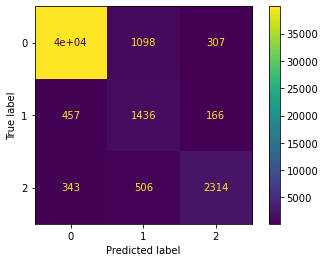

In [12]:
params = {'tree_method': 'hist','eta' : 0.05, 'max_depth': 5, 'n_estimators': 100, 'colsample_bytree' : 0.8, 'max_delta_step' : 1}

bst = xgb.XGBClassifier(params)
evaluate_model(bst, X_train, y_train, X_test, y_test)

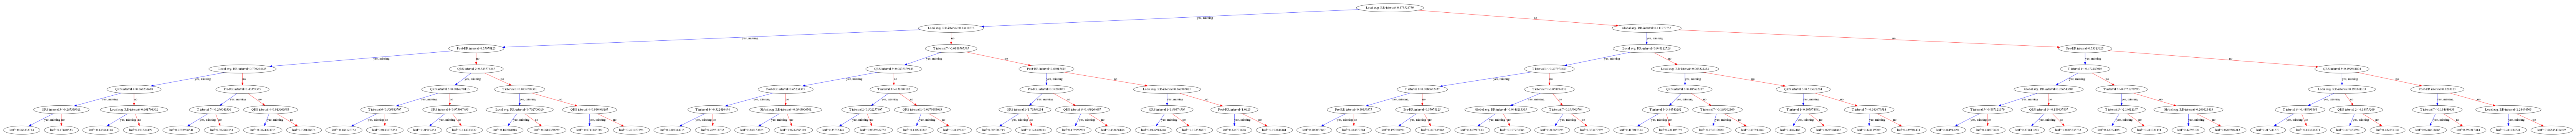

In [19]:
# Visualize tree - double tap to zoom
plt.rcParams['figure.figsize'] = [120,100]
xgb.plot_tree(bst, num_trees=0)
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

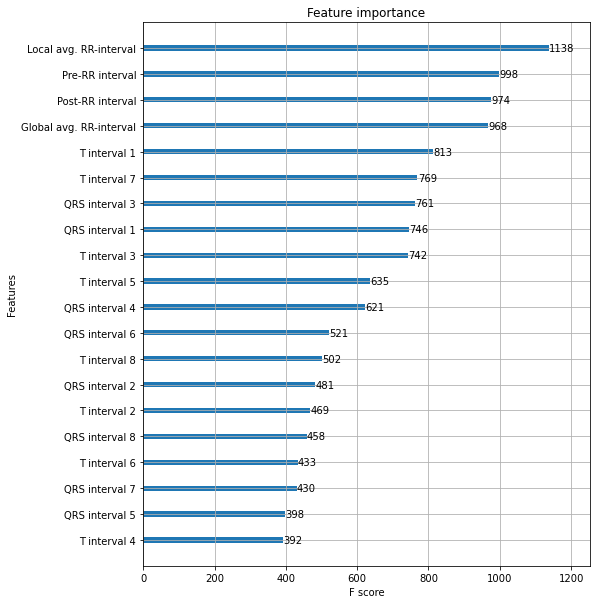

In [20]:
# Feature importance
plt.rcParams['figure.figsize'] = [8, 10]
xgb.plot_importance(bst)
#plt.show()

### Support Vector Classifier (linear)

Cross-validation
Accuracy:  [0.83567225 0.87284957 0.85661622 0.82893545 0.83094037]
Accuracy (mean):  0.845002772316002
Accuracy (std):  0.017048663519236902
Wall time: 4min 1s
Test
accuracy: 0.737
f1 score macro av: 0.671
recall score macro av: 0.737
precision score macro av: 0.640
f1 score for every class:  [0.96116505 0.34030596 0.71108455]
recall:  [0.93032975 0.5293832  0.75245021]
precision:  [0.99411446 0.25074764 0.67403002]
 
Confusion matrix


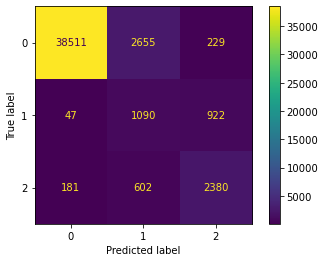

In [25]:
# SVC linear
svc_l = SVC(kernel='linear', class_weight='balanced')
evaluate_model(svc_l, X_sc, y_train, X_scts, y_test)

### LD with SMOTE
Trying to improve LD classifier with combining downsampling N class in half and SMOTE - oversampling minority classes in a specific way. I tried different methods of SMOTE such as BorderlineSMOTE and ADASYN, but the classic one worked best.

Cross-validation
Accuracy:  [0.77096267 0.71351709 0.74429866 0.74425727 0.7449195 ]
Accuracy (mean):  0.743591039445705
Accuracy (std):  0.018200866715489077
Wall time: 483 ms
Test
accuracy: 0.746
f1 score macro av: 0.699
recall score macro av: 0.746
precision score macro av: 0.675
f1 score for every class:  [0.97231693 0.42704126 0.69641156]
recall:  [0.95412489 0.59057795 0.69332912]
precision:  [0.99121618 0.33443344 0.69952153]
 
Confusion matrix


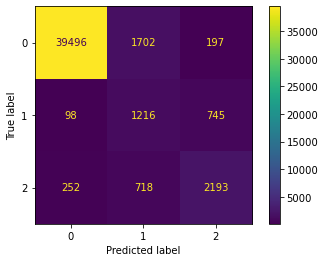

In [46]:
oversample = SMOTE(sampling_strategy={1:round(0.5*pd.Series(y_train).value_counts()[0]), 2:round(0.5*pd.Series(y_train).value_counts()[0])})
X_smote, y_smote = oversample.fit_resample(X_sc, y_train)

# ld_smote classifier
ld_smote = LinearDiscriminantAnalysis()
evaluate_model(ld_smote, X_smote, y_smote, X_scts, y_test)

### Ensemble models - Blending

In [28]:
from sklearn.model_selection import train_test_split
import copy
#not my code
class BlendingAveragedModels():
    def __init__(self, base_models, meta_model, holdout_pct=0.2, use_features_in_secondary=False):
        self.base_models = base_models
        self.meta_model = meta_model
        self.holdout_pct = holdout_pct
        self.use_features_in_secondary = use_features_in_secondary
        
    def fit(self, X, y):
        self.base_models_ = [copy.copy(x) for x in self.base_models]
        self.meta_model_ = copy.copy(self.meta_model)
        
        X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=self.holdout_pct)
                
        holdout_predictions = np.zeros((X_holdout.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models_):
            model.fit(X_train, y_train)
            y_pred = model.predict(X_holdout)
            holdout_predictions[:, i] = y_pred
        if self.use_features_in_secondary:
            self.meta_model_.fit(np.hstack((X_holdout, holdout_predictions)), y_holdout)
        else:
            self.meta_model_.fit(holdout_predictions, y_holdout)
            
        return self
    
    def predict(self, X):
        meta_features = np.column_stack([
            model.predict(X) for model in self.base_models_
        ])
        if self.use_features_in_secondary:
            return self.meta_model_.predict(np.hstack((X, meta_features)))
        else:
            return self.meta_model_.predict(meta_features)

In [35]:
dt_blend = DecisionTreeClassifier()
ld_blend = LinearDiscriminantAnalysis()
params = {'tree_method': 'hist','eta' : 0.05, 'max_depth': 5, 'n_estimators': 100, 'colsample_bytree' : 0.8, 'max_delta_step' : 1}

xgb_blend = xgb.XGBClassifier(params)
svc_blend = SVC(kernel='linear', class_weight='balanced')
lr = LogisticRegression()
blending = BlendingAveragedModels([svc_blend, ld_blend, xgb_blend], lr)

In [59]:
blending.fit(X_sc, y_train)

pred = blending.predict(X_scts)
print('Test MIT')
print_performance(y_test, pred)

Test MIT
accuracy: 0.803
f1 score macro av: 0.774
recall score macro av: 0.803
precision score macro av: 0.762
f1 score for every class:  [0.97336986 0.56628605 0.78121844]
recall:  [0.9655514  0.7105391  0.73379703]
precision:  [0.98131598 0.47072072 0.83519252]
 


(0.8032958399609095,
 0.773624784681089,
 0.8032958399609095,
 0.7624097397728936,
 array([0.97336986, 0.56628605, 0.78121844]),
 array([0.9655514 , 0.7105391 , 0.73379703]),
 array([0.98131598, 0.47072072, 0.83519252]))

## CSV writer

In [84]:
import csv
def write_to_csv(data, y, filename):
    f = open(filename + '.csv', 'w',newline='')

    arr = np.array([[]])
    idx = get_set_idx(data, 160)
    
    tsinf = np.isfinite(X_tsdane_clean).all(1)
    tsnan = np.array(X_tsdane.loc[~pd.isna(X_tsdane['QRS interval 1']), :].index)
    
    for i in idx:
        nans = np.array([])
        b = fixed_interval_morphology_features(data[i]['signal'], data[i]['peaks'], data[i]['sampling_rate'])
        for i,k in enumerate(b[0]):
            if np.isnan(k).any():
                nans = np.append(nans, i).astype(int)
        
        #for j in without_nans:
     #   arr = np.append(arr,[j, data[i]['fname']])
            
   # arr = arr.reshape(len(y), 2)
   # arr = np.column_stack((arr, y))
    
   # with f:

    #    writer = csv.writer(f)
    #    writer.writerows((arr))

    return arr

In [22]:
def get_set_idx(data, limit):
    seed = get_best_seed(np.arange(0,limit),list(data.keys()), round(0.75*len(data)), data)
    random.seed(seed)
    pts_train = random.sample(list(data.keys()), round(0.75*len(data))) 
    pts_test = [pt for pt in list(data.keys()) if pt not in pts_train]
    
    return pts_test

In [256]:
write_to_csv(dane, y_pred_dane_bl, 'blending')
write_to_csv(dane, y_pred_dane_bst, 'xgb')
write_to_csv(dane, y_pred_dane_ld_smote, 'ldsmote')
write_to_csv(dane, y_pred_dane_svc, 'svc')

array([['0', '../../medapp_data_all/32471', '0'],
       ['1', '../../medapp_data_all/32471', '1'],
       ['2', '../../medapp_data_all/32471', '0'],
       ...,
       ['21', '../../medapp_data_all/386', '0'],
       ['22', '../../medapp_data_all/386', '0'],
       ['23', '../../medapp_data_all/386', '1']], dtype='<U32')

## Results

The data in MIT-BIH SVT database is highly imbalanced (N class is 88% of all peaks in db). 
One approach to this problem is to downsample the majority class ('N') in half or to the number of S class samples. However we lose some important information during this process. The performance of models is higher than without downsampling, but models don't perform well on another db or real-world signals.
Second approach is to use SMOTE (Synthetic Minority Oversampling Technique) which gave better results in terms of accuracy of models. SMOTE combined with downsampling the N class gave the best performance, however it needs to be checked if another data set will be classified. 

Another important thing was to split data on patients, not on samples and then choosing the random seed which produces the most balanced data split, this helped to prevent data leakage seen previously.The article didn't mention other form of compensating the N class problem than introducing weights to LD model.  I learned that decision trees often perform well on imbalanced datasets because their hierarchical structure allows them to learn signals from all classes. That's why it had the best overall score previously. But because of the fact that that scikit implementation might be outdated I used XGBoosted Tree. The hyper-parameter tuning was performed with grid search. 


The results for SMOTE + downsampling increased the score for LD classifier, however it did not for SVC and XGBoost. Therefore I got rid of plain LD and only left LD with SMOTE.
I used StandardScaler to scale the data in order to get more reasonable results on other data sets such as arrythmia db. Another change was to calculate global avg differently (as difference between global and local), it reduced correlation and imporved scores slightly. Further than that I decreased number of samples on fixed interval morphology to 8 and it again improved the scores slightly. Changed the number of estimators in XGB to a lot more (from 8 to 100). 

## Visualizing classified peaks

In [54]:
def show_classified_for_model(record, model, start_time, end_time):
    X_record = X_prepare(dict({0: record}))
    
    X_record = pd.DataFrame((scaler.transform(X_record)))
    y_pred = model.predict(X_record)
    draw_classified_beats(record, y_pred, start_time, end_time, model.__class__.__name__)

def draw_classified_beats(signal, y_pred, start_time, end_time, title):
    peaks = signal['peaks']

    n_peaks = peaks[y_pred == 0]
    s_peaks = peaks[y_pred == 1]
    v_peaks = peaks[y_pred == 2]
    
    fig = plt.figure(figsize=(15,5)) 
    draw_peaks(title, signal['signal'], n_peaks, start_time, end_time, signal['sampling_rate'], fig, 'N beat',c='y')
    draw_peaks(title, signal['signal'], s_peaks, start_time, end_time, signal['sampling_rate'], fig, 'S beat',c='m')
    draw_peaks(title, signal['signal'], v_peaks, start_time, end_time, signal['sampling_rate'], fig, 'V beat',c='c')


def draw_peaks(title, signal, peak_loc, start_time, end_time, Fs, fig=None, label=None, c='r'):
    
    '''
    Parameters:
    title - string, title of graph
    signal - ecg signal values
    peak_loc - array of R peaks locations in signal (indices) 
    start_time - int, start on time axis for drawing graph in seconds, default 0
    end_time - int, end on time axis for drawing graph, default 5
    Fs - int, sampling frequency
    '''
    
    t = np.arange(0, signal.size/Fs, 1./Fs)  
    peak_val = signal[peak_loc]
   
    # alteration for drawing peaks from different class on one figure
    if fig is None:
        fig = plt.figure(figsize=(15,5)) 
    
    ax = fig.add_subplot(111)
        
    ax.axis([start_time, end_time, min(signal) - (max(signal) - min (signal))*0.1, max(signal) + (max(signal) - min (signal))*0.1])
    ax.set_title(title, fontsize = 22)
    ax.set_xlabel('Time [s]', fontsize = 18)
    ax.set_ylabel('Amplitude [a.u.]', fontsize = 18)
    ax.grid()
    ax.plot(t, signal, c='tab:blue',lw=2)
    ax.plot(t[peak_loc], peak_val, c+'o', label = label)
    ax.legend(loc='upper right')

### 5:55 record
Here is 5:55 recording of real-world ECG data. There should be few characteristic peaks to distinguish here.

In [49]:
ecg_record = load_signals('symulator EKG/ecg updated','i')

records loaded: 16 from: symulator EKG/ecg updated omitted files 0


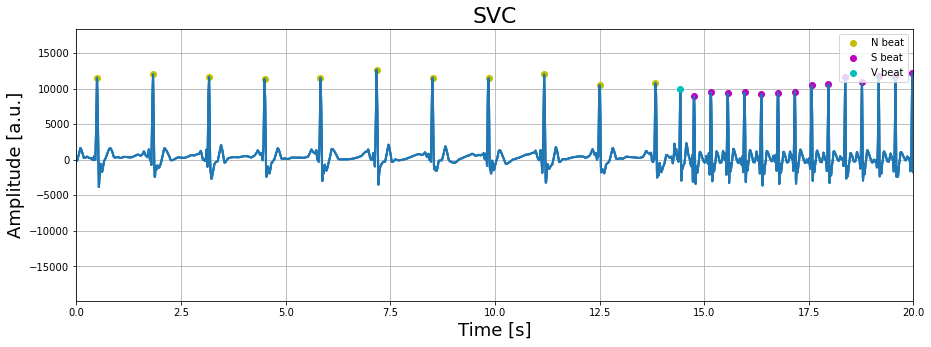

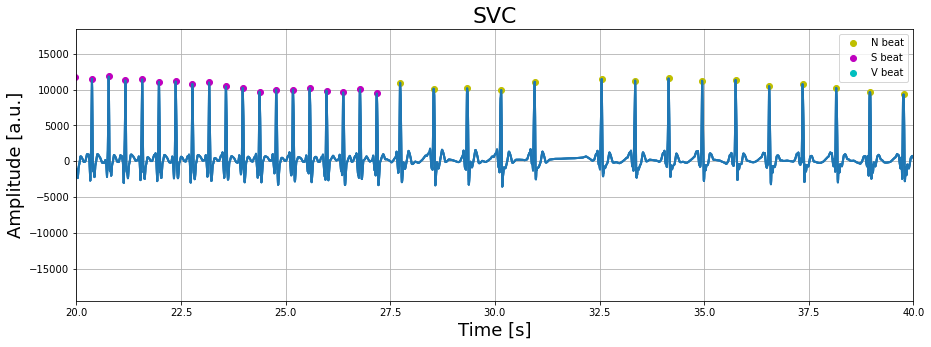

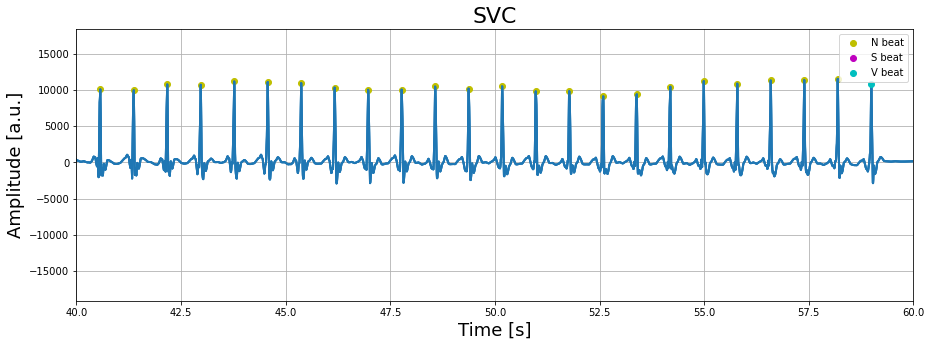

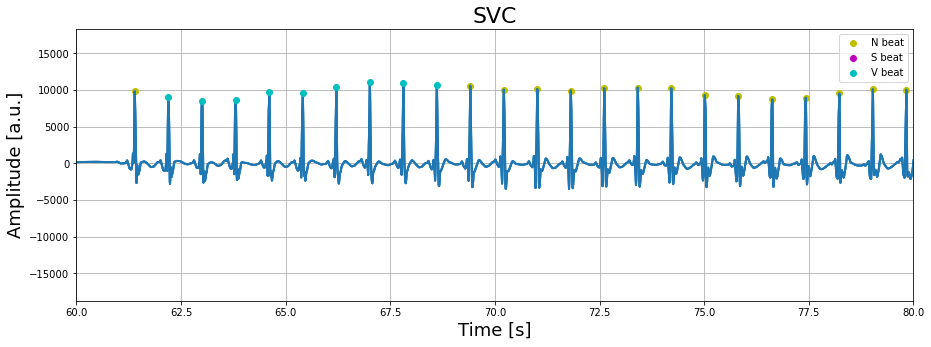

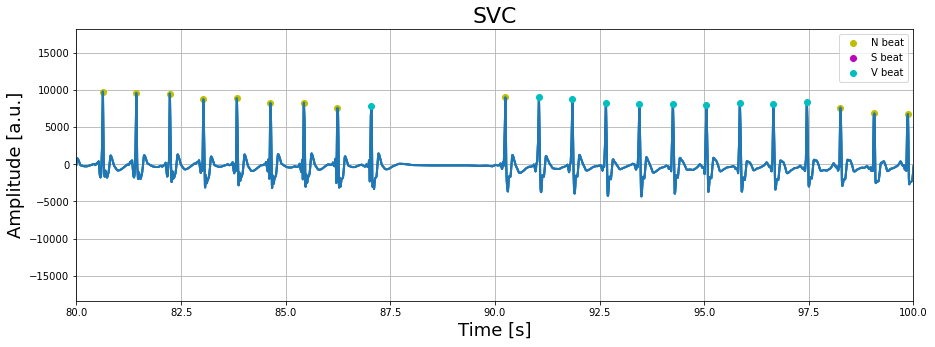

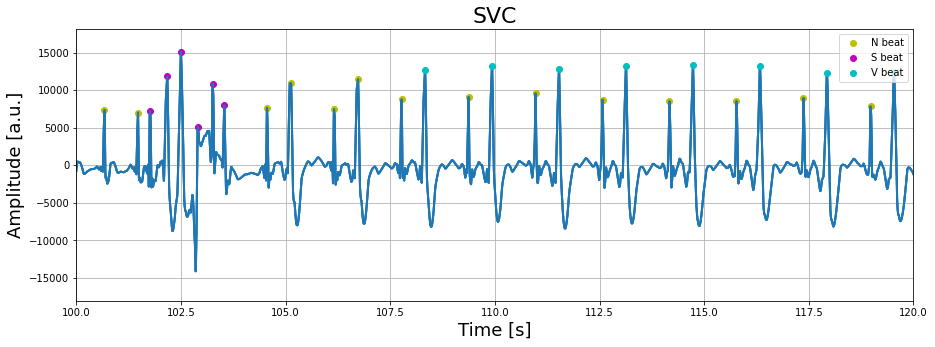

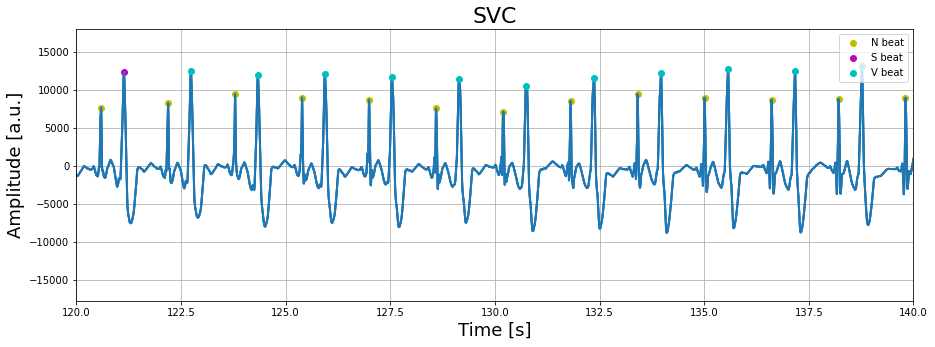

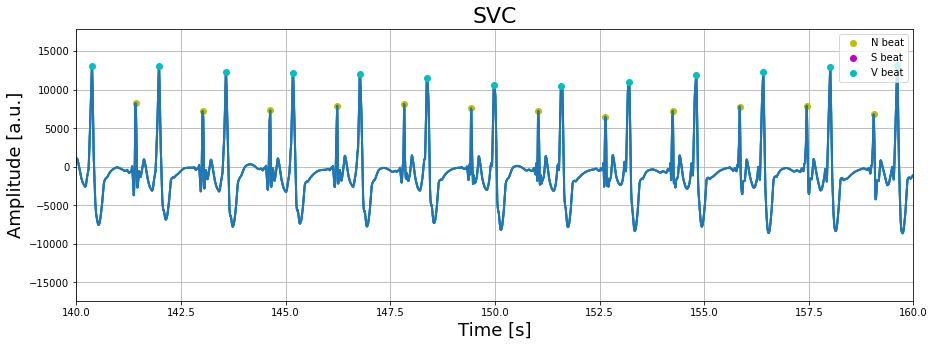

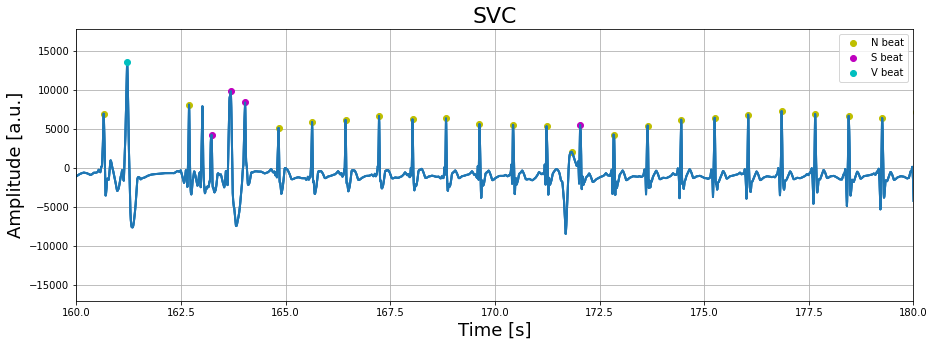

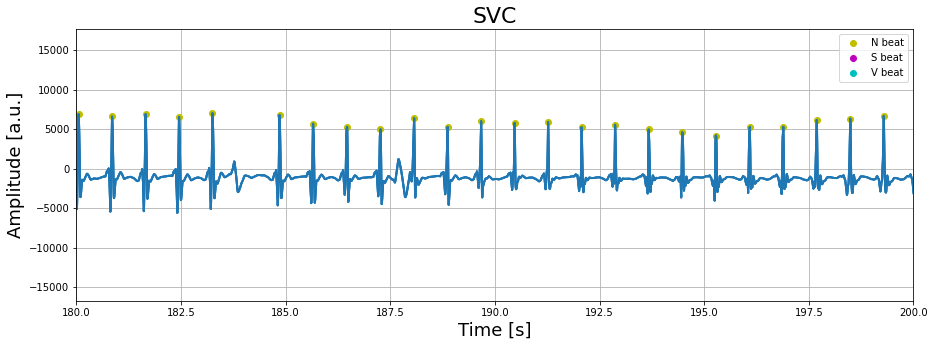

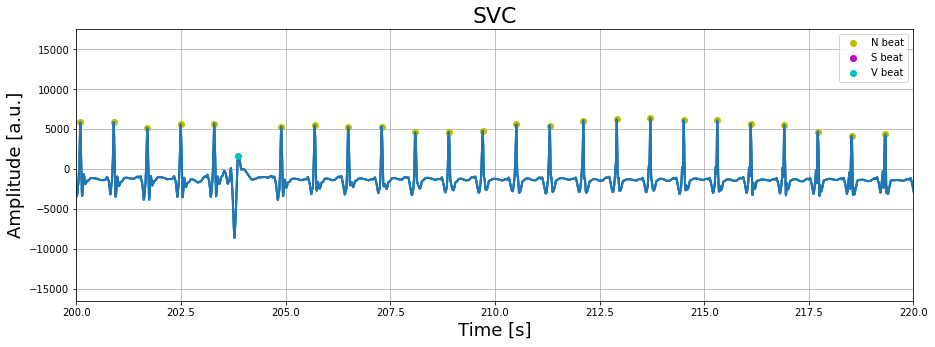

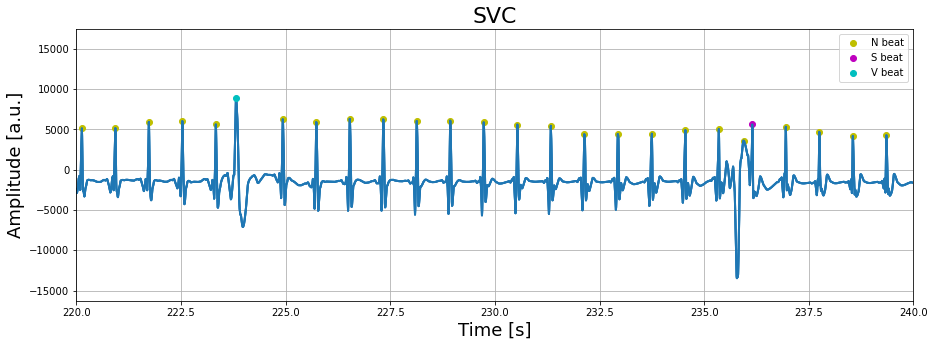

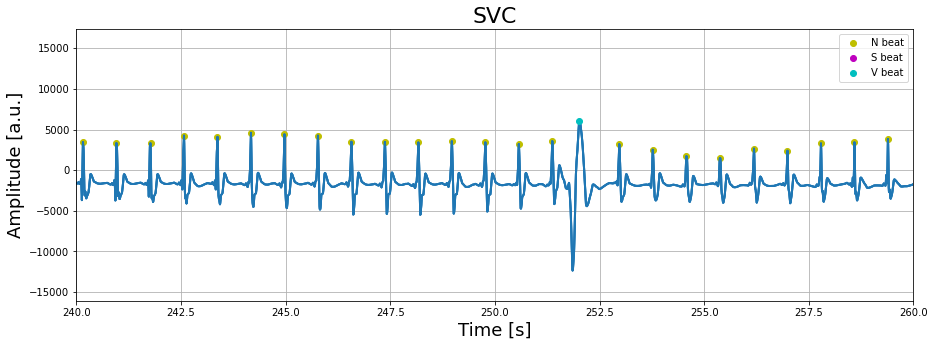

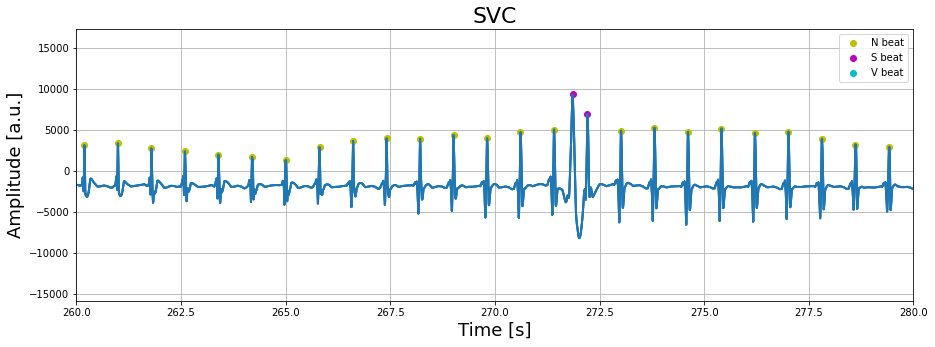

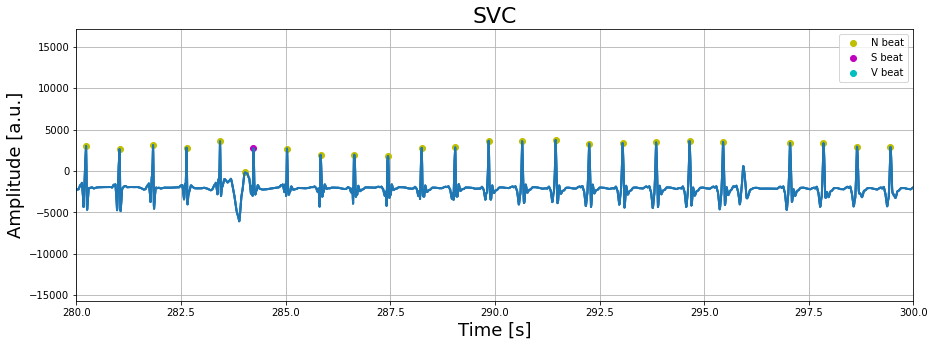

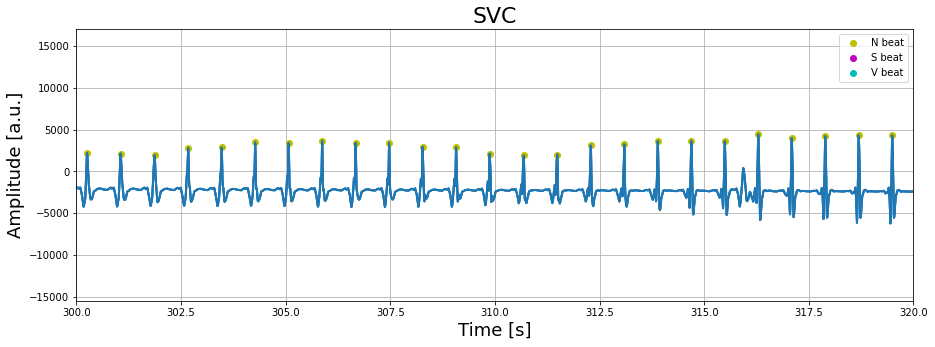

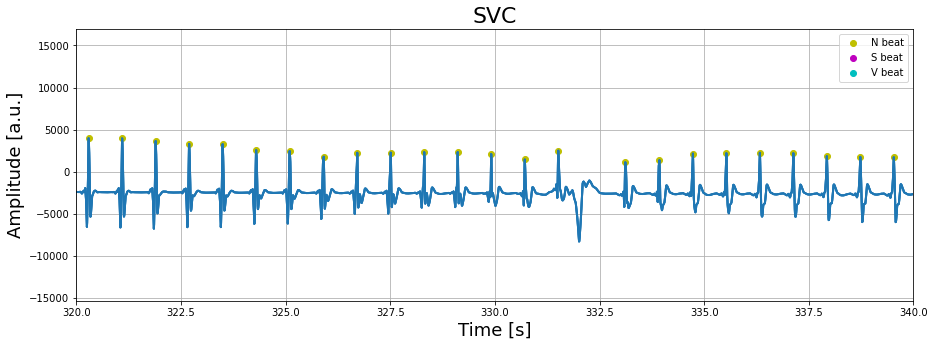

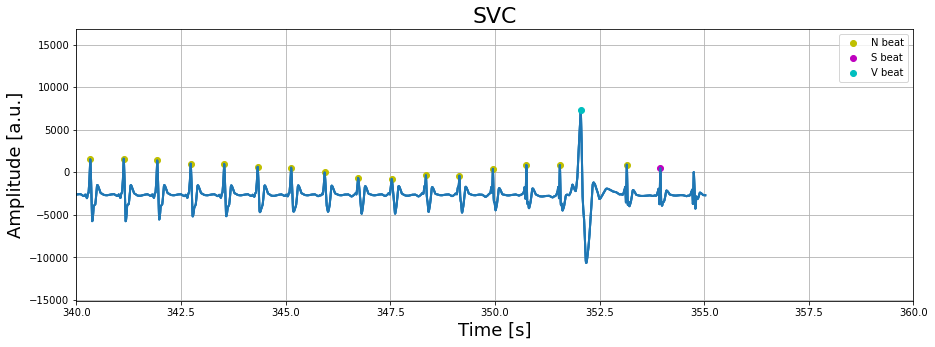

In [56]:
# whole signal, one model
record = ecg_record[4]
record_len = len(record['signal'])
for i in range(0, round(record_len/200),20):
    show_classified_for_model(record, svc_l, i, 20+i) # other classifiers: ld_smote, svc_l, dt

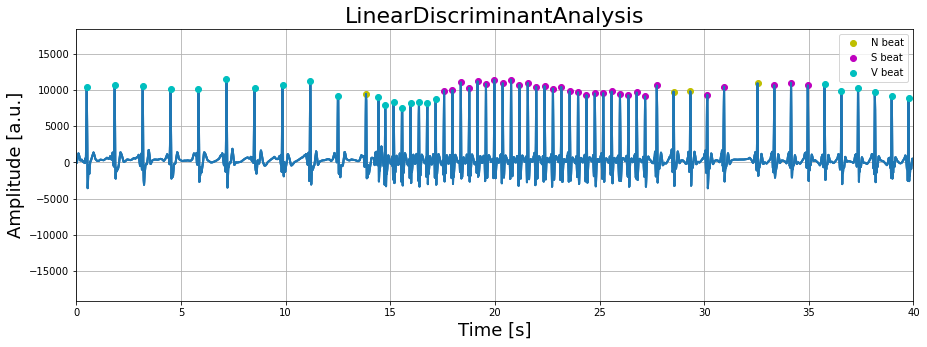

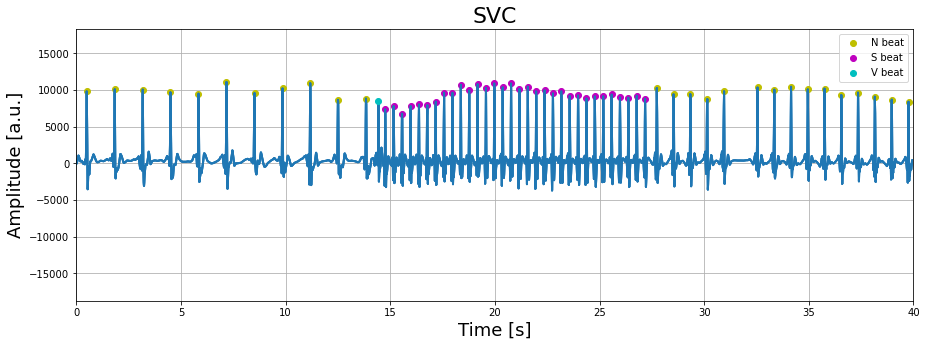

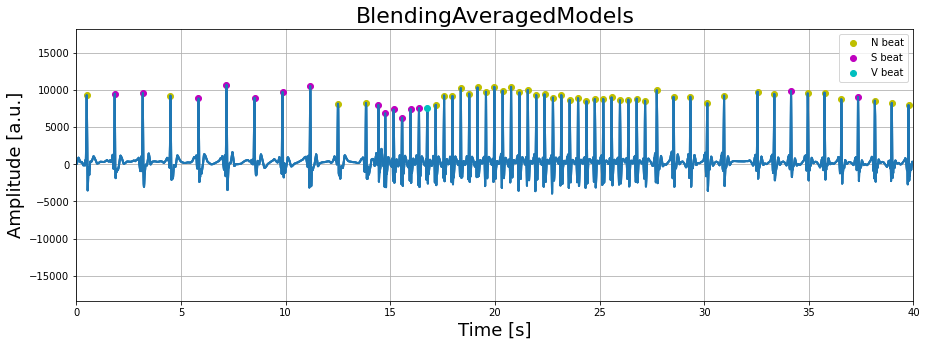

In [60]:
# draw one part of signal but compare all classifiers
models = [ld_smote, svc_l, blending]
for model in models:
    show_classified_for_model(record, model, 0, 40)